# Fine-Tuning BERT on GLUE - MRPC

From [Microsoft Research Paraphrase Corpus](https://www.microsoft.com/en-us/download/details.aspx?id=52398):

A text file containing 5800 pairs of sentences which have been extracted from news sources on the web, along with human annotations indicating whether each pair captures a paraphrase/semantic equivalence relationship. No more than 1 sentence has been extracted from any given news article. 

## 0. Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
from pathlib import Path

from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "mrpc"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [3]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA GeForce RTX 4060 Ti

==============NVSMI LOG==============

Timestamp                                 : Sat Jan 11 22:59:57 2025
Driver Version                            : 550.135
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:07:00.0
    FB Memory Usage
        Total                             : 16380 MiB
        Reserved                          : 307 MiB
        Used                              : 1335 MiB
        Free                              : 14740 MiB
    BAR1 Memory Usage
        Total                             : 256 MiB
        Used                              : 24 MiB
        Free                              : 232 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## Dataset

In [4]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [5]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [6]:
pd.DataFrame(dataset["train"]).sample(10)

,sentence1,sentence2,label,idx
179,Tibco has used the Rendezvous name since 1994 ...,Tibco has used the Rendezvous name since 1994 ...,1,201
2679,Most of the alleged spammers engaged in fraudu...,""" Spam knows no borders , "" said Brad Smith , ...",0,2977
3133,"Yesterday , Taiwan reported 35 new infections ...",The island reported another 35 probable cases ...,1,3482
1061,"A month ago , the Commerce Department estimate...","A month ago , the Commerce Department said GDP...",1,1187
1091,Gillespie sent a letter to CBS President Lesli...,Republican National Committee Chairman Ed Gill...,0,1220
2230,A New Castle County woman has become the first...,A 62-year-old West Babylon man has contracted ...,0,2483
2287,He admits he occasionally lived the life of a ...,Schwarzenegger has admitted to occasionally li...,1,2544
149,U.S. law enforcement officials are sneering at...,U.S. law enforcement officials are sneering at...,1,167
965,He reportedly claims Prime Minister Sir Allan ...,He was reported as saying Prime Minister Sir A...,1,1078
450,History will remember the University of Washin...,"Dr. Belding Scribner , inventor of a device th...",0,502


In [7]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([1, 0])
num_labels=2


The GLUE benchmark suite keeps the labels for its test dataset secret. This is a common practice in many machine learning benchmarks. By withholding the labels for the test set, it is ensured that the test set is used solely for evaluating the performance of models and models may not be trained on it. This encourages researchers to focus on developing models that generalize well, rather than optimizing for achieving a high score on the specific test set.

In [8]:
pd.DataFrame(dataset["test"]).sample(10)

,sentence1,sentence2,label,idx
646,Larger publishers such as Viacom Inc . ' s VIA...,Larger publishers such as Simon & Schuster and...,1,646
1589,This year the Audubon Society once again hosts...,It 's the National Audubon Society 's annual C...,0,1589
40,Cisco pared spending during the quarter to com...,"In response to sluggish sales , Cisco pared sp...",1,40
1037,Grassley and Baucus rejected any disparity in ...,Grassley and Baucus said they had rejected tha...,1,1037
1685,But a senior State Department official said : ...,""" We 'll decide how to keep the proper incenti...",1,1685
1349,"If Fortigel , a testosterone gel , had been ap...","If Fortigel had been approved , Cellegy would ...",1,1349
197,The survey also found that executives who feel...,The survey also found that more executives fee...,1,197
1325,"Dubbed Project Mad Hatter , the Linux-based de...","Designed to compete with Microsoft Corp. , Pro...",1,1325
853,Rusch has also allowed five or more earned run...,Redman has allowed two earned runs or less in ...,0,853
242,Wal-Mart estimates more than 100 million Ameri...,Each week 138 million shoppers visit Wal-Mart ...,1,242


The only way to get an evaluation on the testing dataset is to train a model and sent it to the University of New York - which maintains the GLUE benchmark leaderboard - for evaluation. However this option only exists for researches about to publish a paper, therefore we can't do that.

Instead, we will split the training dataset to create a custom test dataset for our experiment. We will keep the validation split as it is.

In [9]:
new_train_test_split = dataset['train'].train_test_split(test_size=0.1)
new_train_test_split

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3301
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 367
    })
})

In [10]:
dataset['train'] = new_train_test_split['train']
dataset['test'] = new_train_test_split['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3301
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 367
    })
})

We now have a test dataset with labels, which is __not__ part of our training data:

In [11]:
pd.DataFrame(dataset["test"]).sample(10)

,sentence1,sentence2,label,idx
274,But when no justice announced a retirement whe...,But when neither Justice O 'Connor nor any oth...,1,1836
34,The cards are issued by Mexico 's consulates t...,The card is issued by Mexico 's consulates to ...,1,2678
51,""" Please , keep doing your homework , "" said B...",""" Please , keep doing your homework , "" said B...",1,4064
198,That would give smokers the right to take comp...,He agrees that technically smoking could be co...,1,1294
339,It is rare for a legal challenge to occur befo...,Experts say legal challenges are rare before a...,1,910
144,Launched from the space shuttle Atlantis in 19...,Launched from space shuttle Atlantis ( news - ...,1,2996
191,"Even after he turned 94 , Lacy worked to chang...","Even into his 90s , Lacy worked to change the ...",1,2101
217,Their difference was over whether the court sh...,Their difference was over whether the court sh...,1,522
297,"And if we don 't do this , innocent people on ...","Crews are told : "" If we don 't do this , inno...",1,157
226,The number of injured dropped to 2.92 million ...,"At the same time , the number of injuries drop...",1,3675


## 2. BERT-base

In [12]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

### 2.1 Tokenization

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [14]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Max length in split='train': 103
Max length in split='validation': 86
Max length in split='test': 87


In [15]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Here is an example of a tokenized dataset item:

In [ ]:
with pd.option_context('display.max_colwidth', 400):
    display(pd.DataFrame(tokenized_dataset["train"][:1]).transpose())

,0
sentence1,"Its shares fell 71 cents , or 3.5 percent , in after-hours trading to $ 19.55 ."
sentence2,"The stock had risen 63 cents , or 3 percent , to close at $ 20.26 in regular-session Nasdaq trading ."
label,0
idx,1805
input_ids,"[101, 2049, 6661, 3062, 6390, 16653, 1010, 2030, 1017, 1012, 1019, 3867, 1010, 1999, 2044, 1011, 2847, 6202, 2000, 1002, 2539, 1012, 4583, 1012, 102, 1996, 4518, 2018, 13763, 6191, 16653, 1010, 2030, 1017, 3867, 1010, 2000, 2485, 2012, 1002, 2322, 1012, 2656, 1999, 3180, 1011, 5219, 17235, 2850, 4160, 6202, 1012, 102]"
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

#### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,101,2049,6661,3062,6390,16653,1010,2030,1017,1012,...,1999,3180,1011,5219,17235.0,2850.0,4160.0,6202.0,1012.0,102.0
1,101,2002,2056,1996,4001,2038,4484,13412,8268,17853,...,2165,2436,1012,102,NaN,NaN,NaN,NaN,NaN,NaN
2,101,1996,3066,2003,3395,2000,1050,2475,2232,2475,...,8094,4284,1997,2494,1012.0,102.0,NaN,NaN,NaN,NaN


In [18]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,101,2049,6661,3062,6390,16653,1010,2030,1017,1012,...,1999,3180,1011,5219,17235,2850,4160,6202,1012,102
1,101,2002,2056,1996,4001,2038,4484,13412,8268,17853,...,2165,2436,1012,102,0,0,0,0,0,0
2,101,1996,3066,2003,3395,2000,1050,2475,2232,2475,...,8094,4284,1997,2494,1012,102,0,0,0,0


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

### 2.2 Metrics

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [19]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [20]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mnli-mm": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [ ]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy', 'f1']" as an evaluation metric for the task mrpc


In [22]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 2.3 Training

In [23]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [26]:
from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [27]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_base = trainer.train()

--- training_arguments.output_dir='/home/markhun/Development/groups/192.039-2024W/bert/training/glue-mrpc/google-bert_bert-base-uncased'
--- training_arguments.metric_for_best_model='f1'


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.571700,0.452132,0.799020,0.867742
2,0.387600,0.387357,0.823529,0.871886
3,0.242100,0.433872,0.843137,0.889655
4,0.147800,0.497208,0.845588,0.891566
5,0.095700,0.535898,0.848039,0.892734


In [28]:
training_summary_bert_base

TrainOutput(global_step=520, training_loss=0.2889928359251756, metrics={'train_runtime': 118.3429, 'train_samples_per_second': 139.468, 'train_steps_per_second': 4.394, 'total_flos': 679089633884160.0, 'train_loss': 0.2889928359251756, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [29]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.535897970199585,
 'eval_accuracy': 0.8480392156862745,
 'eval_f1': 0.8927335640138409,
 'eval_runtime': 0.7259,
 'eval_samples_per_second': 562.064,
 'eval_steps_per_second': 17.909,
 'epoch': 5.0}

In [30]:
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.5717,12.273488,0.000016,104,0.452132,0.799020,0.867742,0.7487,544.947,17.363,NaN,NaN,NaN,NaN,NaN
2,0.3876,3.130206,0.000012,208,0.387357,0.823529,0.871886,0.7551,540.347,17.217,NaN,NaN,NaN,NaN,NaN
3,0.2421,2.809153,0.000008,312,0.433872,0.843137,0.889655,0.7231,564.220,17.978,NaN,NaN,NaN,NaN,NaN
4,0.1478,0.448242,0.000004,416,0.497208,0.845588,0.891566,0.7201,566.550,18.052,NaN,NaN,NaN,NaN,NaN
5,0.0957,0.428589,0.000000,520,0.535898,0.848039,0.892734,0.8345,488.905,15.578,118.3429,139.468,4.394,6.790896e+14,0.288993


### Loss and Evaluation Metrics over Training Steps

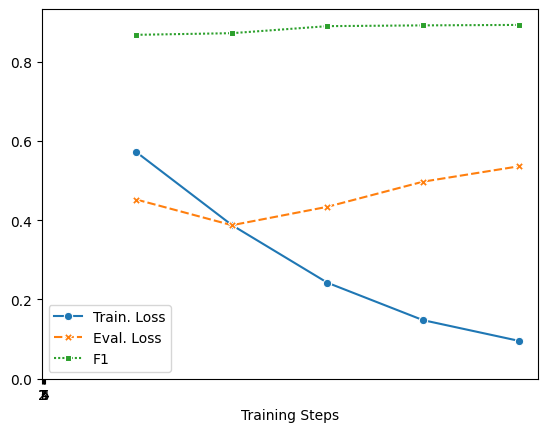

In [31]:
import seaborn as sns

data = training_history_bert_base[["loss", "eval_loss", "step", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "F1"]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Steps']).dropna()


plot = sns.lineplot(data=data, x="Training Steps", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown("### Loss and Evaluation Metrics over Training Steps"))

### 2.4 Evaluation

### Label frequency in test dataset

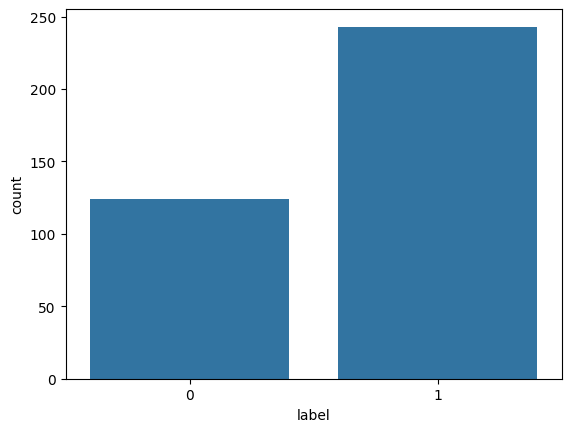

In [32]:
import seaborn as sns

sns.countplot(x='label', data=pd.DataFrame(tokenized_dataset["test"]))

from IPython.display import Markdown, display
display(Markdown("### Label frequency in test dataset"))

The dataset classes seem to be unbalanced.

In [33]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-base-uncased)

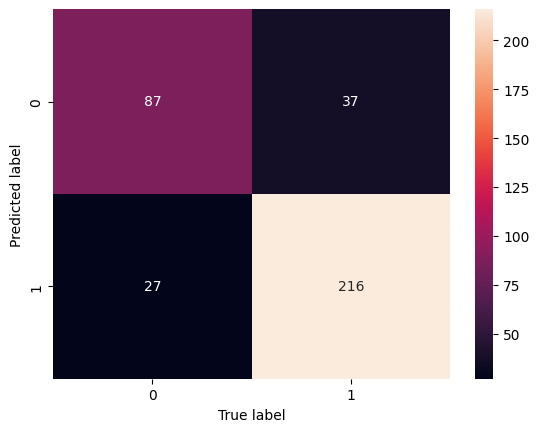

In [34]:
import sklearn.metrics

bert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [35]:
predictions.metrics

{'test_loss': 0.5215994715690613,
 'test_accuracy': 0.8256130790190735,
 'test_f1': 0.8709677419354839,
 'test_runtime': 0.6621,
 'test_samples_per_second': 554.305,
 'test_steps_per_second': 18.124}

In [36]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    [training_summary_bert_base.metrics["train_runtime"]]
    + list(best_model_evaluation.values())
    + [ predictions.metrics["test_accuracy"], predictions.metrics["test_f1"]],
    index=["train_runtime_s"] + list(best_model_evaluation.keys()) + ["test_accuracy", "test_f1"],
    columns=["our BERT_BASE"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)

# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", "-", "-",  "-",  "-", 0.889]
results["original BERT_LARGE"] = ["-", "-",  "-",  "-",  "-", 0.893]
print(
    '"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.'
)
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,original BERT_LARGE
train_runtime_s,118.342900,-,-
eval_loss,0.535898,-,-
eval_accuracy,0.848039,-,-
eval_f1,0.892734,-,-
test_accuracy,0.825613,-,-
test_f1,0.870968,0.889,0.893


## 3. BERT-Large

In [37]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-large-uncased"

### 3.1 Tokenization

In [38]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

In [39]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3.2 Metrics

In [40]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy', 'f1']" as an evaluation metric for the task mrpc


In [41]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 3.3 Training

In [42]:
BATCH_SIZE = 16  # BERT-large might need a smaller batch size

In [43]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

8251

In [44]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_large = trainer.train()

--- training_arguments.output_dir='/home/markhun/Development/groups/192.039-2024W/bert/training/glue-mrpc/google-bert_bert-large-uncased'
--- training_arguments.metric_for_best_model='f1'


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.562000,0.372195,0.845588,0.894472
2,0.316900,0.327467,0.860294,0.898032
3,0.158800,0.456300,0.879902,0.913884
4,0.082300,0.631730,0.870098,0.910321
5,0.039900,0.651886,0.882353,0.917241


In [46]:
training_summary_bert_large

TrainOutput(global_step=1035, training_loss=0.23198272502364745, metrics={'train_runtime': 443.4643, 'train_samples_per_second': 37.218, 'train_steps_per_second': 2.334, 'total_flos': 2287542022708992.0, 'train_loss': 0.23198272502364745, 'epoch': 5.0})

In [47]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.651885986328125,
 'eval_accuracy': 0.8823529411764706,
 'eval_f1': 0.9172413793103448,
 'eval_runtime': 2.1755,
 'eval_samples_per_second': 187.539,
 'eval_steps_per_second': 11.951,
 'epoch': 5.0}

In [48]:
training_history_bert_large = pd.DataFrame(trainer.state.log_history)
training_history_bert_large.epoch = training_history_bert_large.epoch.astype(int)
training_history_bert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.5620,11.102053,0.000016,207,0.372195,0.845588,0.894472,2.1579,189.071,12.049,NaN,NaN,NaN,NaN,NaN
2,0.3169,3.524104,0.000012,414,0.327467,0.860294,0.898032,2.1882,186.451,11.882,NaN,NaN,NaN,NaN,NaN
3,0.1588,0.240943,0.000008,621,0.456300,0.879902,0.913884,2.1834,186.867,11.908,NaN,NaN,NaN,NaN,NaN
4,0.0823,0.154750,0.000004,828,0.631730,0.870098,0.910321,2.1743,187.643,11.958,NaN,NaN,NaN,NaN,NaN
5,0.0399,0.033756,0.000000,1035,0.651886,0.882353,0.917241,2.2608,180.470,11.501,443.4643,37.218,2.334,2.287542e+15,0.231983


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-large-uncased)

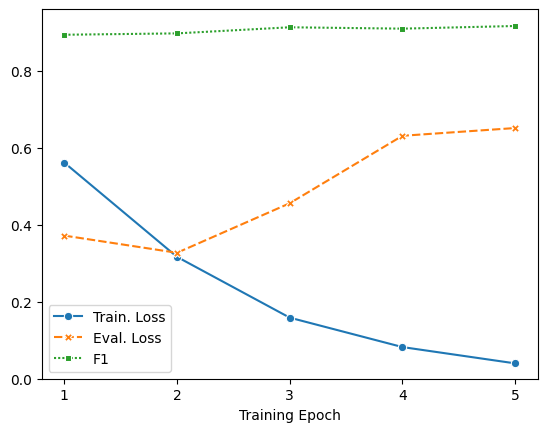

In [49]:
import seaborn as sns

data = training_history_bert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [50]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-large-uncased)

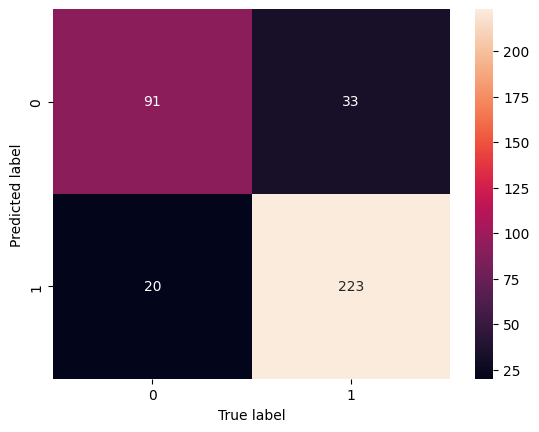

In [51]:
import sklearn.metrics

bert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [52]:
predictions.metrics

{'test_loss': 0.8069601655006409,
 'test_accuracy': 0.8555858310626703,
 'test_f1': 0.8937875751503006,
 'test_runtime': 2.0107,
 'test_samples_per_second': 182.521,
 'test_steps_per_second': 11.439}

In [53]:
display(Markdown(f"### Best Model performance:"))
results["our BERT_LARGE"] = [
    training_summary_bert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    best_model_evaluation["eval_f1"],
    predictions.metrics["test_accuracy"],
    predictions.metrics["test_f1"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,118.342900,-,443.464300,-
eval_loss,0.535898,-,0.651886,-
eval_accuracy,0.848039,-,0.882353,-
eval_f1,0.892734,-,0.917241,-
test_accuracy,0.825613,-,0.855586,-
test_f1,0.870968,0.889,0.893788,0.893


## 4. ModernBERT-base

In [54]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-base" 

### 4.1 Tokenization

In [55]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [56]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [57]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy', 'f1']" as an evaluation metric for the task mrpc


In [58]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [59]:
BATCH_SIZE = 32

In [60]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

5320

In [61]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_base = trainer.train()

--- training_arguments.output_dir='/home/markhun/Development/groups/192.039-2024W/bert/training/glue-mrpc/answerdotai_ModernBERT-base'
--- training_arguments.metric_for_best_model='f1'


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.539600,0.398074,0.813725,0.873333
2,0.304800,0.327767,0.867647,0.899254
3,0.117300,0.505836,0.850490,0.891652
4,0.034000,0.805123,0.865196,0.906303
5,0.008000,0.871240,0.867647,0.905923


In [63]:
training_summary_modernbert_base

TrainOutput(global_step=520, training_loss=0.2007246080499429, metrics={'train_runtime': 99.6918, 'train_samples_per_second': 165.56, 'train_steps_per_second': 5.216, 'total_flos': 890198592211404.0, 'train_loss': 0.2007246080499429, 'epoch': 5.0})

In [64]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.8080391883850098,
 'eval_accuracy': 0.8676470588235294,
 'eval_f1': 0.9081632653061225,
 'eval_runtime': 0.5572,
 'eval_samples_per_second': 732.248,
 'eval_steps_per_second': 23.331,
 'epoch': 5.0}

In [65]:
training_history_modernbert_base = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_base.epoch = training_history_modernbert_base.epoch.astype(int)
training_history_modernbert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.5396,27.849356,0.000064,104,0.398074,0.813725,0.873333,0.4963,822.064,26.193,NaN,NaN,NaN,NaN,NaN
2,0.3048,2.153966,0.000048,208,0.327767,0.867647,0.899254,0.4780,853.560,27.197,NaN,NaN,NaN,NaN,NaN
3,0.1173,0.113358,0.000032,312,0.505836,0.850490,0.891652,0.5764,707.795,22.552,NaN,NaN,NaN,NaN,NaN
4,0.0340,0.004257,0.000016,416,0.805123,0.865196,0.906303,0.4950,824.199,26.261,NaN,NaN,NaN,NaN,NaN
5,0.0080,0.003172,0.000000,520,0.871240,0.867647,0.905923,0.6333,644.273,20.528,99.6918,165.56,5.216,8.901986e+14,0.200725


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-base)

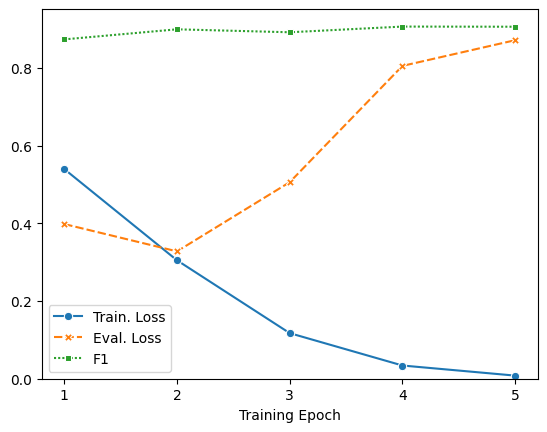

In [66]:
import seaborn as sns

data = training_history_modernbert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [67]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-base)

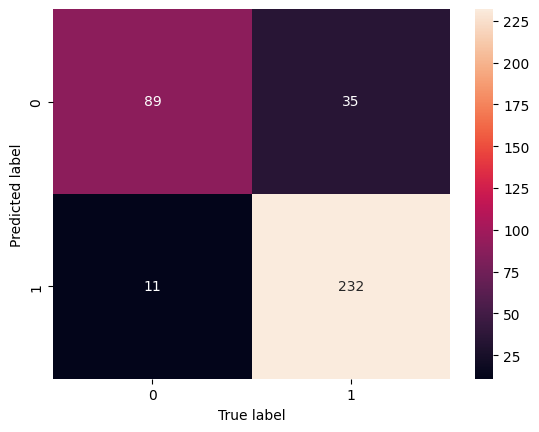

In [68]:
import sklearn.metrics

modernbert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [69]:
predictions.metrics

{'test_loss': 0.7727545499801636,
 'test_accuracy': 0.8746594005449592,
 'test_f1': 0.9098039215686274,
 'test_runtime': 0.4807,
 'test_samples_per_second': 763.475,
 'test_steps_per_second': 24.964}

In [70]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_BASE"] = [
    training_summary_modernbert_base.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    best_model_evaluation["eval_f1"],
    predictions.metrics["test_accuracy"],
    predictions.metrics["test_f1"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


/tmp/ipykernel_615424/1140528142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["our ModernBERT_BASE"] = [


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,118.342900,-,99.691800,443.464300,-
eval_loss,0.535898,-,0.808039,0.651886,-
eval_accuracy,0.848039,-,0.867647,0.882353,-
eval_f1,0.892734,-,0.908163,0.917241,-
test_accuracy,0.825613,-,0.874659,0.855586,-
test_f1,0.870968,0.889,0.909804,0.893788,0.893


## 5. ModernBERT-Large

In [71]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-large" 

### 4.1 Tokenization

In [72]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [73]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [74]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy', 'f1']" as an evaluation metric for the task mrpc


In [75]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [76]:
BATCH_SIZE = 16

In [77]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()
torch.cuda.empty_cache()

In [78]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_large = trainer.train()

--- training_arguments.output_dir='/home/markhun/Development/groups/192.039-2024W/bert/training/glue-mrpc/answerdotai_ModernBERT-large'
--- training_arguments.metric_for_best_model='f1'


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.686000,0.622228,0.683824,0.810573
2,0.412000,0.375845,0.860294,0.904523
3,0.243100,0.389458,0.870098,0.906526
4,0.082700,0.728243,0.860294,0.901554
5,0.017900,0.743294,0.877451,0.912892


In [80]:
training_summary_modernbert_large

TrainOutput(global_step=1035, training_loss=0.28831954532199433, metrics={'train_runtime': 347.2597, 'train_samples_per_second': 47.529, 'train_steps_per_second': 2.98, 'total_flos': 2628293141896716.0, 'train_loss': 0.28831954532199433, 'epoch': 5.0})

In [81]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.7450714111328125,
 'eval_accuracy': 0.8774509803921569,
 'eval_f1': 0.9128919860627178,
 'eval_runtime': 1.1747,
 'eval_samples_per_second': 347.332,
 'eval_steps_per_second': 22.134,
 'epoch': 5.0}

In [82]:
training_history_modernbert_large = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_large.epoch = training_history_modernbert_large.epoch.astype(int)
training_history_modernbert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.6860,14.778546,0.000064,207,0.622228,0.683824,0.810573,1.2953,314.990,20.073,NaN,NaN,NaN,NaN,NaN
2,0.4120,4.173042,0.000048,414,0.375845,0.860294,0.904523,1.2890,316.521,20.170,NaN,NaN,NaN,NaN,NaN
3,0.2431,1.548667,0.000032,621,0.389458,0.870098,0.906526,1.2999,313.877,20.002,NaN,NaN,NaN,NaN,NaN
4,0.0827,0.004149,0.000016,828,0.728243,0.860294,0.901554,1.3395,304.601,19.411,NaN,NaN,NaN,NaN,NaN
5,0.0179,0.003601,0.000000,1035,0.743294,0.877451,0.912892,1.5175,268.858,17.133,347.2597,47.529,2.98,2.628293e+15,0.28832


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-large)

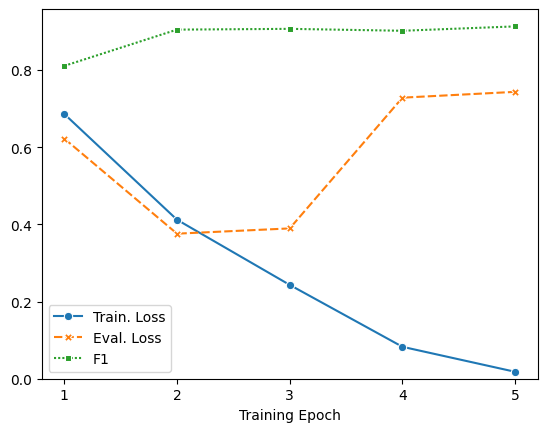

In [83]:
import seaborn as sns

data = training_history_modernbert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [84]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-large)

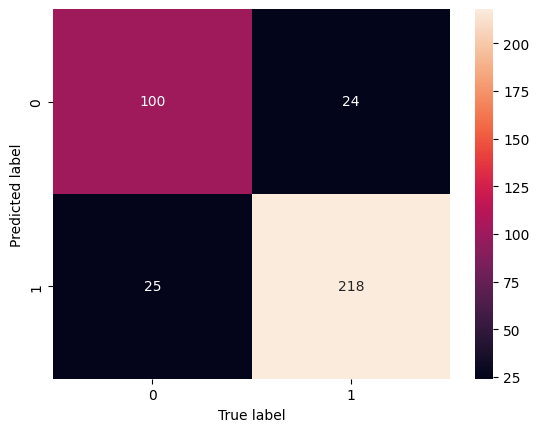

In [85]:
import sklearn.metrics

modernbert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [86]:
predictions.metrics

{'test_loss': 0.6398654580116272,
 'test_accuracy': 0.8664850136239782,
 'test_f1': 0.8989690721649485,
 'test_runtime': 1.0976,
 'test_samples_per_second': 334.354,
 'test_steps_per_second': 20.954}

In [87]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_LARGE"] = [
    training_summary_modernbert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    best_model_evaluation["eval_f1"],
    predictions.metrics["test_accuracy"],
    predictions.metrics["test_f1"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
        "our ModernBERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


/tmp/ipykernel_615424/131768545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["our ModernBERT_LARGE"] = [


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,118.342900,-,99.691800,443.464300,-,347.259700
eval_loss,0.535898,-,0.808039,0.651886,-,0.745071
eval_accuracy,0.848039,-,0.867647,0.882353,-,0.877451
eval_f1,0.892734,-,0.908163,0.917241,-,0.912892
test_accuracy,0.825613,-,0.874659,0.855586,-,0.866485
test_f1,0.870968,0.889,0.909804,0.893788,0.893,0.898969


# Summary

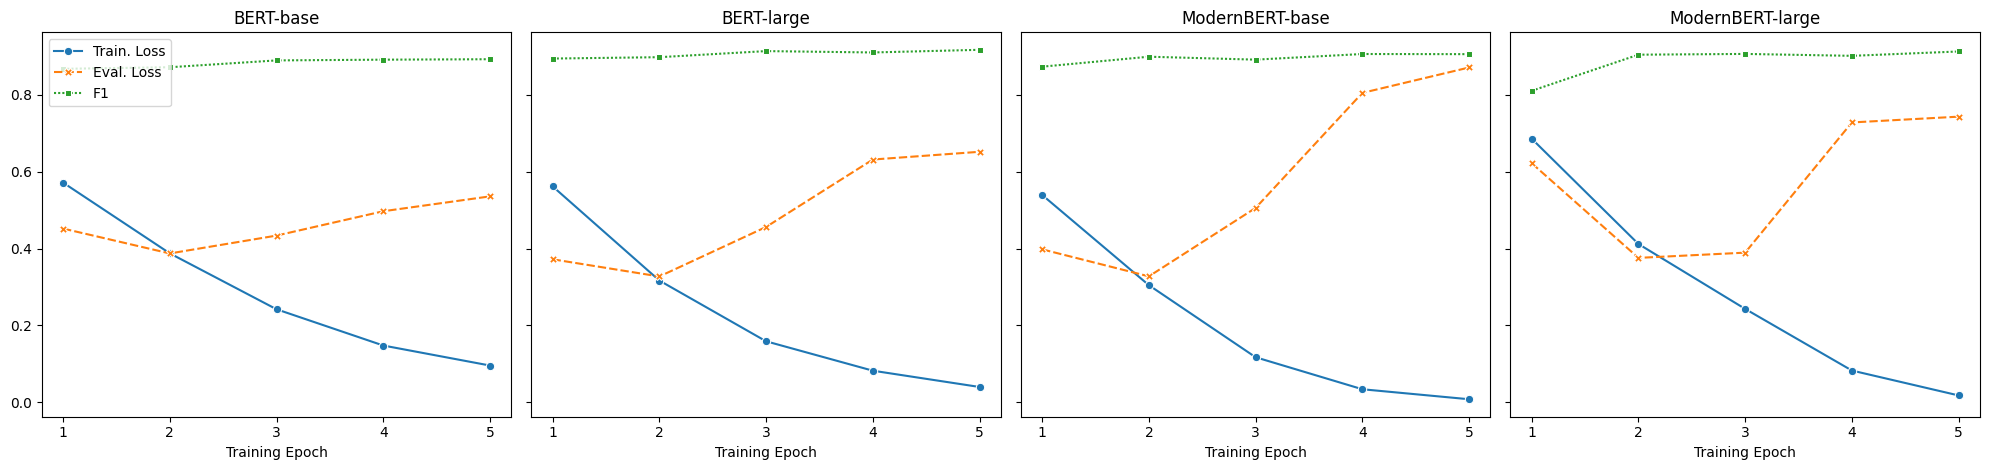

In [88]:
import matplotlib.pyplot as plt

titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
training_histories = [training_history_bert_base, training_history_bert_large, training_history_modernbert_base, training_history_modernbert_large]

fig, axes = plt.subplots(ncols=len(training_histories), sharey=True)

def draw_loss_eval_plot(title, history, ax):
    data = history[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
    data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
    data = data[:-1]
    data = pd.melt(data, ['Training Epoch']).dropna()

    plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True, ax=ax)
    plot.set_ylabel("")
    plot.set(xticks=list(set(history.epoch)))
    plot.legend(title="", loc='upper left')
    plot.set_title(title)

for title, history, ax in zip(titles, training_histories, axes):
    draw_loss_eval_plot(title, history, ax)

for ax in axes[1:]:
    ax.get_legend().remove()

fig.set_figwidth(20)
fig.tight_layout()

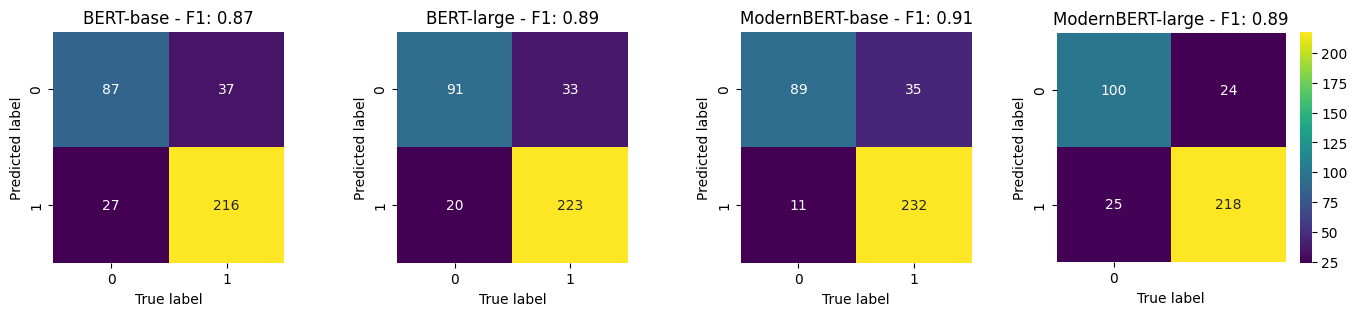

In [89]:
titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
titles = [title + " - " + f"F1: {acc:.2f}" for title, acc in zip(titles, results.loc["test_f1"])]
cms = [bert_base_cm, bert_large_cm, modernbert_base_cm, modernbert_large_cm]

fig, axes = plt.subplots(ncols=len(cms),  figsize=(3,3))

def draw_confusion_matrix_plot(title, cm, ax):
    include_cbar = title == titles[-1]
    plot = sns.heatmap(cm, annot=True, fmt='d', square=True, cmap="viridis", cbar=include_cbar, ax=ax)
    plot.set_xlabel("True label")
    plot.set_ylabel("Predicted label")
    plot.set_title(title)

for title, history, ax in zip(titles, cms, axes):
    draw_confusion_matrix_plot(title, history, ax)

fig.set_figwidth(17)

In [90]:
results

,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,118.342900,-,99.691800,443.464300,-,347.259700
eval_loss,0.535898,-,0.808039,0.651886,-,0.745071
eval_accuracy,0.848039,-,0.867647,0.882353,-,0.877451
eval_f1,0.892734,-,0.908163,0.917241,-,0.912892
test_accuracy,0.825613,-,0.874659,0.855586,-,0.866485
test_f1,0.870968,0.889,0.909804,0.893788,0.893,0.898969


In [91]:
speedup = results["our BERT_BASE"]["train_runtime_s"] / results["our ModernBERT_BASE"]["train_runtime_s"] 
speedup

np.float64(1.1870876039955143)

For this GLUE task `ModernBERT-base` even slightly exceeds the prediction performance of `BERT-large`. Futhermore it achieves a runtime performance speedup of `1.19` over `BERT-base`.